##### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf
import warnings
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

%matplotlib inline
warnings.filterwarnings('ignore')

##### Definition of Helper Functions

In [2]:
def error_table(model_name, y_real, y_pred):
    mae = mean_absolute_error(y_real, y_pred)
    mape = mean_absolute_percentage_error(y_real, y_pred)
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))

    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index = [model_name])

In [3]:
df = pd.read_csv("../data/week_sales.csv", usecols=['Date', 'Store', 'Sales'], parse_dates=['Date'], index_col='Date')
y = df.copy()
y['Sales'] = np.log1p(y['Sales'])
#df.sort_index(ascending=False, inplace=True)
display(y)

,Store,Sales
Date,,
2012-12-31,1,10.185541
2012-12-31,2,10.007082
2012-12-31,3,10.479117
2012-12-31,4,10.798126
2012-12-31,5,9.939964
...,...,...
2015-07-27,1111,10.029547
2015-07-27,1112,10.546420
2015-07-27,1113,10.235988


##### Create a separate train- and test time series for each store:

In [4]:
# 8 weeks before the last date
test_date = y.index[-1]- datetime.timedelta(weeks=7)

y_train = []
y_test = []
for store in np.sort(y['Store'].unique()):
    # a time series per store 
    store_mask = y['Store'] == store
    store_df = y[store_mask]
    # append time series
    y_train.append(store_df[store_df.index < test_date]['Sales'])
    y_test.append(store_df[store_df.index >= test_date]['Sales'])

##### Autoregressive Model AR(p)

Plot a global autocorrelation plot, to decide which lag(s) to include in the model

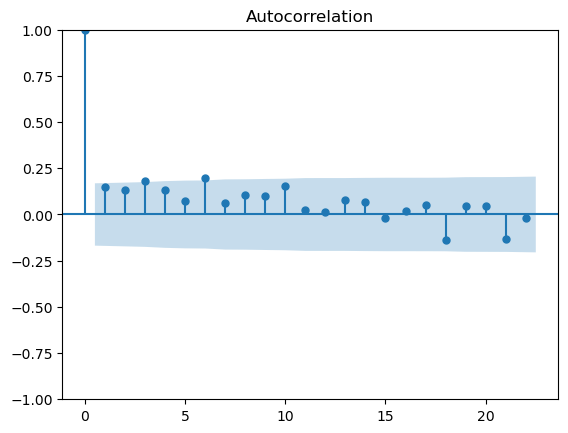

In [5]:
global_y = df.groupby('Date').sum().drop('Store', axis=1)
global_y['Sales'] = np.log1p(global_y['Sales'])
plot_acf(global_y['Sales']);

We will train an autoregressive model with lags 3 and 6 for each store

In [6]:
#Toy example
#y_train_0 = y_train[0]['Sales']
#y_test_0 = y_test[0]['Sales']

#ar_model = AutoReg(y_train_0, lags=[3,6])
#ar_results = ar_model.fit()
#y_pred_0 = ar_results.predict(start=len(y_train_0), end=len(y_train_0) + len(y_test_0) - 1, dynamic=False)

#error_table( 'AR(1)', np.expm1(y_test_0), np.expm1(y_pred_0))

In [7]:
y_pred_ar = []

for store in np.sort(y['Store'].unique()):
    train = y_train[store - 1]
    test = y_test[store - 1]
    ar_model = AutoReg(train, lags=[3,6])
    ar_results = ar_model.fit()
    pred = ar_results.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
    y_pred_ar.append(pred)

In [9]:
y_test_vals = np.concatenate([s.values for s in y_test])
y_pred_ar_vals = np.concatenate([s.values for s in y_pred_ar])

error_table( 'AR(3,6)', np.expm1(y_test_vals), np.expm1(y_pred_ar_vals))

,Model Name,MAE,MAPE,RMSE
"AR(3,6)","AR(3,6)",3827.417608,0.098492,5366.146233
